# Notebook to format data from "Metabolic Rate, Body Composition, Foraging Success, Behavior, and GPS Locations of Female Polar Bears (Ursus maritimus), Beaufort Sea, Spring, 2014-2016 and Resting Energetics of an Adult Female Polar Bear: U.S. Geological Survey data release", Pagano (2018).

Data can be found [here](https://alaska.usgs.gov/products/data.php?dataid=174).

See also [this paper](https://www.int-res.com/articles/esr2017/32/n032p019.pdf).

Some awesome [video footage](https://www.youtube.com/watch?v=qXQBjZLNYT0)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import datetime
import tqdm

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/pagano_bears'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/pagano_bears'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
features_fps = os.path.join(raw_data_dir, 'PolarBear_archival_logger_data_southernBeaufortSea_2014_2016_revised.csv')
annotations_fps = os.path.join(raw_data_dir, 'PolarBear_video-derived_behaviors_southernBeaufortSea_2014_2016_revised_w_ACC_corrected_times.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 16
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'pagano_bears'

In [6]:
data = pd.read_csv(features_fps)
annotations = pd.read_csv(annotations_fps)

In [7]:
individuals = sorted(data['Bear'].unique())
individuals = [int(x) for x in individuals]

In [8]:
individuals

[3, 5, 6, 7, 8, 9]

We are going to drop bear 3 from analysis. This bear was recorded in 2014, and the annotations are only at 30 second resolution

In [9]:
data = data[data['Bear'] != 3]
individuals.remove(3)
individuals

[5, 6, 7, 8, 9]

In [17]:
# Split tracks into 3 hour clips, so that life is more manageable
# Keep track of which individual is associated to which clip_id

data['clip_id'] = 'clip_' + str(0)

clip_size_samples = 1728000 # This is 3 hours of recording at 16 Hz
current_clip_id = 0
clip_ids = []

clip_id_to_individual_id = {}
for individual in individuals:
    indices = data[data['Bear'] == individual].index
    x = 0
    while x< len(indices):
        selected = indices[x : x +clip_size_samples]
        data.loc[selected, 'clip_id'] = 'clip_' + str(current_clip_id)
        clip_ids.append('clip_' + str(current_clip_id))
        clip_id_to_individual_id['clip_' + str(current_clip_id)] = individual
        current_clip_id += 1
        x += clip_size_samples

In [18]:
## Integer codes for individuals

dataset_metadata['individual_ids'] = individuals # There are 5 individuals with tag data
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id
dataset_metadata['clip_ids'] = clip_ids

In [19]:
# Set up data splits: divide individuals across folds for cross validation

n_folds = 5
dataset_metadata['n_folds'] = n_folds
individuals_per_fold = {i : [] for i in range(n_folds)}

for pointer, individual in enumerate(individuals):
    individuals_per_fold[pointer % n_folds].append(individual)
    
dataset_metadata['individuals_per_fold'] = individuals_per_fold
    
print(individuals_per_fold)
print("There are %d individuals" % len(individuals))

{0: [5], 1: [6], 2: [7], 3: [8], 4: [9]}
There are 5 individuals


In [20]:
# Set up clip ids 

clip_ids_per_fold = {i : [] for i in range(n_folds)}
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    for fold in range(n_folds):
        if individual in individuals_per_fold[fold]:
            clip_ids_per_fold[fold].append(clip_id)
for fold in range(n_folds):
    clip_ids_per_fold[fold] = sorted(clip_ids_per_fold[fold])

dataset_metadata['clip_ids_per_fold'] = clip_ids_per_fold

## Create dataset-level metadata

In [21]:
# for individual in individuals:
#     print(annotations[annotations['Bear'] == individual]['Behavior'].value_counts())

In [22]:
# Favor labels which are long enough in duration to last for the annotation period, and which are abundant

obs_beh_to_beh_name = {
    'laying' : 'rest',
    'walking' : 'walk',
    'mixed' : 'unknown',
    'adjusting' : 'unknown', 
    'sitting or standing' : 'rest',
    'head shake' : 'head_shake',
    'sitting or laying' : 'rest',
    'rolling in snow' : 'roll',
    'unknown' : 'unknown',
    'eating' : 'eat',
    'digging' : 'dig',
    'grooming' : 'groom',
    'interacting' : 'unknown',
    'smelling snow' : 'unknown',
    'swimming' : 'swim',
    'running' : 'run',
    'eating snow' : 'eat',
    'pouncing' : 'pounce',
    'standing' : 'rest',
    'running and walking' : 'unknown',
    'carrying carcass' : 'unknown',
    'breeding' : 'unknown',
    'rubbing' : 'unknown',
    'jumping' : 'unknown',
    'breaking into liar' : 'unknown',
    'sticking head out of water' : 'unknown',
    'moving ice' : 'unknown',
    'catches seal' : 'unknown',
    'biting seal' : 'unknown',
    'crawling through ice cavern' : 'unknown',
    'sticking head into water' : 'unknown',
    'hauling out of water' : 'unknown',
    'standing up' : 'unknown',
    'standing ' : 'rest',
    'standing or sitting' : 'rest',
    '#NAME?' : 'unknown'
}

In [23]:
## Integer codes for specific behaviors

beh_names = sorted(set([obs_beh_to_beh_name[k] for k in obs_beh_to_beh_name]))
beh_names.remove('unknown')
beh_names.insert(0, 'unknown')

print(beh_names)

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

['unknown', 'dig', 'eat', 'groom', 'head_shake', 'pounce', 'rest', 'roll', 'run', 'swim', 'walk']


In [24]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'Wetdry', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [25]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

In [26]:
# how many annotations?
len(annotations[annotations['Bear'].isin(individuals)])

31288

## Format Clip Data

In [27]:
# add annotations to data

annotations['ACC_corrected_Datetime_behavior_start'] = pd.to_datetime(annotations['ACC_corrected_Datetime_behavior_start'])
annotations['ACC_corrected_Datetime_behavior_end'] = pd.to_datetime(annotations['ACC_corrected_Datetime_behavior_end'])
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [28]:
# Convenience function to detect nans.
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

#Interpolates all nan values of given array
def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

In [29]:
#data['beh_label'] = 'unknown'
data['beh_int_label'] = 0

total_dur_samples = 0
total_annotation_dur_samples = 0

for individual in individuals:
    data_sub = data[data['Bear'] == individual].copy()
    annotations_sub = annotations[annotations['Bear'] == individual]
    #add annotations for that individual
    print("adding annotations for individual %d" % individual)
    for i, row in tqdm.tqdm(annotations_sub.iterrows(), total = len(annotations_sub)):
        # Add annotations, accounting for synchronization
        # offset = time_corrections[individual](row['ACC_corrected_Datetime_behavior_start'])
        start = row['ACC_corrected_Datetime_behavior_start'] #+ offset
        end = row['ACC_corrected_Datetime_behavior_end'] #+ offset
        obs_beh = row['Behavior']
        selected = data_sub[(data_sub['Datetime'] >= start) & (data_sub['Datetime'] <= end)].index
        #data.loc[selected, 'beh_label'] = obs_beh_to_beh_name[obs_beh]
        data_sub.loc[selected, 'beh_int_label'] = beh_str_to_int[obs_beh_to_beh_name[obs_beh]]
        
    # For each clip, create and save the data in the correct format
    print("processing clips for individual %d" % individual)
    for clip_id in tqdm.tqdm(clip_ids):
        individual_id = clip_id_to_individual_id[clip_id]
        if individual_id != individual:
            continue
            
        # load features
        data_sub_clip = data_sub[data_sub['clip_id'] == clip_id].copy()
        features = np.array(data_sub_clip[['Int_aX', 'Int_aY', 'Int_aZ']])
        clip_dur_samples = np.shape(features)[0]
        total_dur_samples+= clip_dur_samples
            
        # Water conductivity
        wetdry = interpolate_nan(np.array(data_sub_clip['Wetdry']))
        wetdry = np.expand_dims(wetdry, axis = -1)

        per_frame_annotations = np.array(data_sub_clip['beh_int_label'])
        per_frame_annotations = np.expand_dims(per_frame_annotations, axis = -1)

        # insert individual id

        per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)

        clip_data = np.concatenate([features, wetdry, per_frame_individual_id, per_frame_annotations], axis = 1)

        clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
        np.savetxt(clip_data_fp, clip_data, delimiter=",")
        
        clip_annotation_dur_samples = np.sum(per_frame_annotations > 0)
        total_annotation_dur_samples += clip_annotation_dur_samples

adding annotations for individual 5


100%|██████████| 8061/8061 [18:55<00:00,  7.10it/s]


processing clips for individual 5


100%|██████████| 39/39 [01:29<00:00,  2.29s/it]


adding annotations for individual 6


100%|██████████| 4145/4145 [10:35<00:00,  6.52it/s]


processing clips for individual 6


100%|██████████| 39/39 [01:30<00:00,  2.33s/it]


adding annotations for individual 7


100%|██████████| 4997/4997 [13:42<00:00,  6.07it/s]


processing clips for individual 7


100%|██████████| 39/39 [01:42<00:00,  2.62s/it]


adding annotations for individual 8


100%|██████████| 7561/7561 [15:41<00:00,  8.03it/s]


processing clips for individual 8


100%|██████████| 39/39 [01:12<00:00,  1.86s/it]


adding annotations for individual 9


100%|██████████| 6524/6524 [15:37<00:00,  6.96it/s]


processing clips for individual 9


100%|██████████| 39/39 [01:43<00:00,  2.66s/it]


In [30]:
total_dur_sec = total_dur_samples / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total_annotation_dur_sec = total_annotation_dur_samples / sr
total_annotation_dur_hours = total_annotation_dur_sec / 3600
print("total annotation duration is %f seconds, i.e. %f hours" % (total_annotation_dur_sec, total_annotation_dur_hours))

total duration is 3990300.312500 seconds, i.e. 1108.416753 hours
total annotation duration is 705253.750000 seconds, i.e. 195.903819 hours


In [31]:
data_sub['beh_int_label'].value_counts()

0     9045281
6     2447760
10     432624
2       93648
7       36048
4       11904
1        8976
9        7280
3        3472
8        1280
5        1008
Name: beh_int_label, dtype: int64

## Check it all looks ok

In [32]:
clip_id = clip_ids[4]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')

In [33]:
np.shape(data)

(1728000, 6)

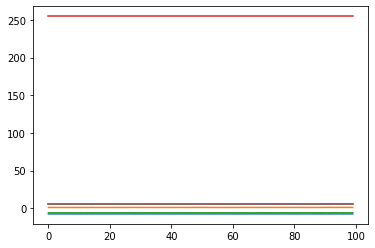

In [34]:
for i in range(np.shape(data)[1]):
    plt.plot(data[1000:1100, i])

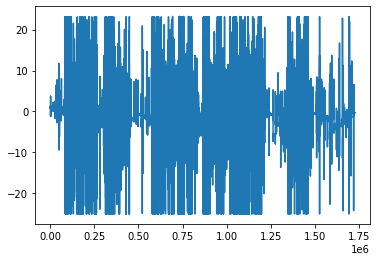

In [35]:
plt.plot(data[:, 1])

## Plot Dataset Summary

In [36]:
# Count class representation

beh_names = dataset_metadata['label_names']
label_count = {fold : {name : 0 for name in beh_names} for fold in range(n_folds)}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        for fold in range(n_folds):
            if clip_id in dataset_metadata['clip_ids_per_fold'][fold]:
                label_count[fold][name] += counts[key]
                
label_perc = {fold : {name : 0 for name in beh_names[1:]} for fold in range(n_folds)}

for name in beh_names[1:]:
    for fold in range(n_folds):
        label_perc[fold][name] = float(label_count[fold][name] / sum([label_count[fold][j] for j in beh_names[1:]]))


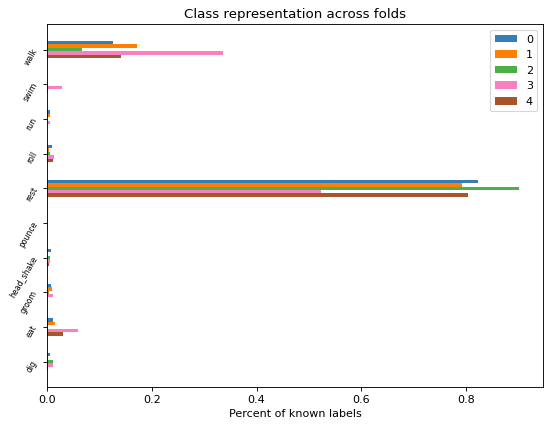

In [37]:
# Plot class representation

# https://gist.github.com/thriveth/8560036#file-cbcolors-py
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.1
plt.figure(figsize=(8, 6), dpi=80)

for fold in range(n_folds):
    current_offset = -(fold - n_folds // 2)*offset
    plt.barh(keys +current_offset, [label_perc[fold][beh_names[key]] for key in keys], height=width, align='center', label = fold, color = CB_color_cycle[fold])
    
plt.title("Class representation across folds")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.svg')

plt.savefig(target_fp, format = 'svg')
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
with open(numerical_target_fp, 'w') as file:
    yaml.dump(label_perc, file)

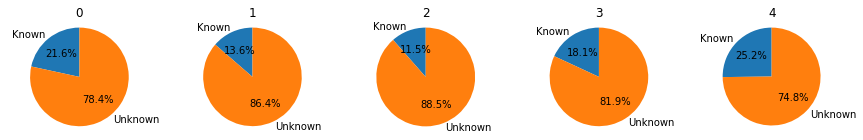

In [38]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
sizes = {fold : [sum([label_count[fold][j] for j in beh_names[1:]]), label_count[fold]['unknown']] for fold in range(n_folds)}
# train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
# val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
# test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,n_folds, figsize = (3*n_folds,2))

for fold in range(n_folds):
    ax[fold].pie(sizes[fold], labels=labels, autopct='%1.1f%%', startangle=90)
    ax[fold].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[fold].set_title(fold)

target_fp = os.path.join(formatted_data_dir, 'perc_known.svg')

plt.savefig(target_fp, format='svg')

plt.show()


## Temporal Statistics

In [39]:
####################################
infill_max_dur_sec = 91 # If annotations are nnnnn0000000nnnnn, where 0=unknown, do we fill in 0's with n's?
####################################

# This cell runs almost as a stand alone, but requires the first few cells of this notebook to be run first

import tqdm
from pathlib import Path

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'r') as file:
    metadata = yaml.safe_load(file)

clip_fps = list(Path(clip_data_dir).glob('*.csv'))

def create_list_of_durations(x, infill_max_dur_sec, samplerate, unknown_value = 0):
    # First pass: create a list of label durations, together with a list of the associated classes
    current_value = 0
    current_dur = 0
    list_of_durs = []
    list_of_labels = []
    for i in x:
        if i == current_value:
            current_dur += 1
        elif i != current_value:
            list_of_durs.append(current_dur / samplerate)
            list_of_labels.append(current_value)
            current_dur = 1
            current_value = i
            
    list_of_durs.append(current_dur)
    list_of_labels.append(current_value)
            
    # repeatedly merge similar labels if they are seperated by unknowns of short duration
    # This is mainly to deal with duty cycling of observations
    infill_max_dur_samples = int(infill_max_dur_sec * samplerate)
    
    if list_of_labels[0] == unknown_value:
        del list_of_labels[0]
        del list_of_durs[0]
        
    if len(list_of_labels) > 0:
        if list_of_labels[-1] == unknown_value:
            del list_of_labels[-1]
            del list_of_durs[-1]
    
    j = 1
    while j<len(list_of_labels)-1:
        if list_of_labels[j] != unknown_value:
            j+= 1
        elif list_of_labels[j-1] == list_of_labels[j+1] and list_of_durs[j] < infill_max_dur_samples:
            # merge if it's a short interval of unknowns between two of the same label
            list_of_durs[j-1] += list_of_durs[j+1]
            del list_of_durs[j+1]
            del list_of_durs[j]
            del list_of_labels[j+1]
            del list_of_labels[j]
        else:
            # otherwise, drop the unknown segment
            del list_of_durs[j]
            del list_of_labels[j]

    return list_of_labels, list_of_durs # list of annotation durations, in samples.
                             
durs_sec_by_individual = {i : [] for i in metadata['individual_ids']}
overall_durs_sec = []
    
for fp in tqdm.tqdm(clip_fps):
    clip_id = fp.stem
    individual_id = metadata['clip_id_to_individual_id'][clip_id]
    clip_annotations = list(pd.read_csv(fp, header = None).values[:, -1])
    l, d = create_list_of_durations(clip_annotations, infill_max_dur_sec, metadata['sr'])
    durs_sec_by_individual[individual_id].extend(d)
    overall_durs_sec.extend(d)
    
mean_dur_sec_by_individual = {i : float(np.mean(durs_sec_by_individual[i])) for i in durs_sec_by_individual}
mean_overall_dur_sec = float(np.mean(overall_durs_sec))

metadata['mean_dur_sec_by_individual'] = mean_dur_sec_by_individual
metadata['mean_overall_dur_sec'] = mean_overall_dur_sec

print("Mean overall label duration is %0.3f seconds" % mean_overall_dur_sec)

print("Re-saving metadata to %s" % str(dataset_metadata_fp))

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(metadata, file)

100%|██████████| 39/39 [02:02<00:00,  3.15s/it]

Mean overall label duration is 127.524 seconds
Re-saving metadata to /home/jupyter/behavior_data_local/data/formatted/pagano_bears/dataset_metadata.yaml
